## The Problem

I have to organize a party for my friends. The problem is that many of my friends do not like each other. Hence I decided to organize the party in two locations. Any of my friends can join either of the parties. But my goal is to minimize the potential conflicts among my friends. A conflict will happen if two of my friends who doesn't like each other joins the same party.

<br>
<br>

## The Genotype

My friends joining one party or the other can be expressed in the following way,

<br>

```
 Bob  Jim   Robin  Anna
[-1,   1,   -1,     1]
```

<br>

1 means they joined party A and -1 means they joined party B.

<br>
<br>

### The weight matrix

We can find the relationships among my friends like below,

<br>

```
        Bob    Jim    Robin    Anna

Bob      0      1       -1       1

Jim      1      0        1      -1

Robin   -1     -1        0       1

Anna     1      1       -1       1
```

<br>

Any of my friend can't like or dislike themselves. An 1 in the weight matrix means that the corresponding friends like each other. A -1 means they don't.

<br>
<br>

### The Fitness Function

We can define the fitness function like below,

<br>
$$ F = \sum\limits_{i=1}^N \sum\limits_{j=1}^N W_{ij}G_{i}G_{j} $$
<br>

We need to write a genetic algorithm to find a combination which minimizes the collision and maximizes the fitness.

One goal is to see how the convergence is affected by crossover.

In [1]:
import numpy as np

In [2]:
# Hyperparameters

POPULATION_SIZE = 100
N_GENES = 50
N_GENERATIONS = 10000
CROSSOVER_RATE = 0.6
MUTATION_RATE = 1 / N_GENES

In [3]:
# Function to generate random weights

def get_weights(n):
    weights = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i != j:
                weights[i][j] = np.random.choice([-1, 1])

    return weights

In [4]:
# Generate random population and random weights

population = np.random.choice([1, -1], size=(POPULATION_SIZE, N_GENES))
w = get_weights(N_GENES)

In [5]:
# Genetic Algorithm Class

class MicrobialEvolutionGA:
    def __init__(self, population, weights, n_generations, n_genes, crossover_rate, mutation_rate, should_crossover):
        # Setup constructor parameters
        # Copy the passed population, so we can reuse it
        self.population = np.array(population)
        self.pop_size = len(population)
        self.weights = weights
        self.n_generations = n_generations
        self.n_genes = n_genes
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.should_crossover = should_crossover

        # Calculate our population fitness
        self.pop_fitness = self.get_population_fitness()

        self.wheel = None
        self.max_wheel = None

        # Init the roulette wheel
        self.init_wheel()

    # Method to initialize the roulette wheel parameters
    def init_wheel(self):
        self.wheel = np.cumsum(range(self.pop_size))
        self.max_wheel = self.wheel[-1]

    # Method to calculate fitness
    def get_fitness(self, ind):
        return sum(
            [sum([self.weights[i][j] * ind[i] * ind[j] for j in range(self.n_genes)]) for i in range(self.n_genes)]
        )

    # Method to calculate fitness for the whole population
    def get_population_fitness(self):
        return np.array([self.get_fitness(ind) for ind in self.population])

    # Select candidates by roulette wheel selection and return their indices in the population
    def select(self, ranked_fitness_indices):
        pick_1 = np.random.rand() * self.max_wheel
        ind_1 = 0
        while pick_1 > self.wheel[ind_1]:
            ind_1 += 1

        pick_2 = np.random.rand() * self.max_wheel
        ind_2 = 0
        while pick_2 > self.wheel[ind_2]:
            ind_2 += 1

        return ranked_fitness_indices[ind_1], ranked_fitness_indices[ind_2]

    # Run tournament among two individuals
    def tournament(self, idx1, idx2):
        fitness_1 = self.get_fitness(self.population[idx1])
        fitness_2 = self.get_fitness(self.population[idx2])
        return (idx1, idx2) if fitness_1 > fitness_2 else (idx2, idx1)

    # Perform crossover between the individuals. Copy winner genes to the loser and return the loser.
    def crossover(self, winner, loser):
        cross_indices = np.array([np.random.rand() < self.crossover_rate for _ in range(self.n_genes)])
        loser[cross_indices] = winner[cross_indices]
        return loser

    # Mutate an individual at a rate of `mutation_rate`, passed as constructor parameter
    def mutate(self, ind):
        mutation_indices = np.array([np.random.rand() < self.mutation_rate for _ in range(self.n_genes)])
        ind[mutation_indices] = ind[mutation_indices] * -1
        return ind

    # Run the evolution algorithm
    def evolution(self):

        # Keep track of the maximum fitness values over generations
        max_fitness_over_time = np.zeros(self.n_generations)

        # Run generations
        for gen in range(self.n_generations):
            # Sort the fitness values and get the sorted indices
            ranked_fitness_indices = np.argsort(self.pop_fitness)
            # Select two individuals according to roulette wheel selection process
            idx_1, idx_2 = self.select(ranked_fitness_indices)
            # Run tournament among the individuals, compute the winner and the loser indices.
            winner_idx, loser_idx = self.tournament(idx_1, idx_2)
            # Get the winner and loser individuals
            winner, loser = self.population[winner_idx], self.population[loser_idx]

            offspring = loser
            # Should we do crossover, according to our passed option?
            if self.should_crossover:
                # Do the crossover, copy winner genes into the loser, to produce offspring
                offspring = self.crossover(winner, loser)
            # Mutate the offspring in random slots
            offspring = self.mutate(offspring)

            # Calculate new fitness of the offspring individual
            new_fitness = self.get_fitness(offspring)
            # Copy the offspring's fitness value in the pop_fitness series.
            self.pop_fitness[loser_idx] = new_fitness
            # Store the maximum fitness of this generation into the max_fitness_over_time array.
            max_fitness_over_time[gen] = np.max(self.pop_fitness)

        # Return the maximum fitness values among generations
        return max_fitness_over_time

    # Get the best solution found so far.
    def best_solution_so_far(self):
        max_fitness = np.argmax(self.pop_fitness)
        return self.population[max_fitness]

    # Get the maximum fitness found so far.
    def max_fitness_so_far(self):
        return np.max(self.pop_fitness)

### Let's run our genetic algorithm with crossover.

In [6]:
np.random.seed(42)

ga_with_crossover = MicrobialEvolutionGA(population, w, N_GENERATIONS, N_GENES, CROSSOVER_RATE, MUTATION_RATE, True)
fitness_over_time_with_crossover = ga_with_crossover.evolution()
ga_with_crossover.max_fitness_so_far(), ga_with_crossover.best_solution_so_far()

(322.0,
 array([ 1, -1,  1,  1,  1, -1, -1, -1, -1, -1,  1,  1,  1, -1, -1, -1, -1,
         1,  1,  1,  1,  1,  1, -1,  1, -1, -1, -1,  1,  1, -1,  1, -1, -1,
        -1,  1, -1, -1,  1,  1, -1,  1,  1,  1, -1,  1,  1, -1, -1, -1]))

Text(0.5, 1.0, 'Max Fitness over Generations with Crossover')

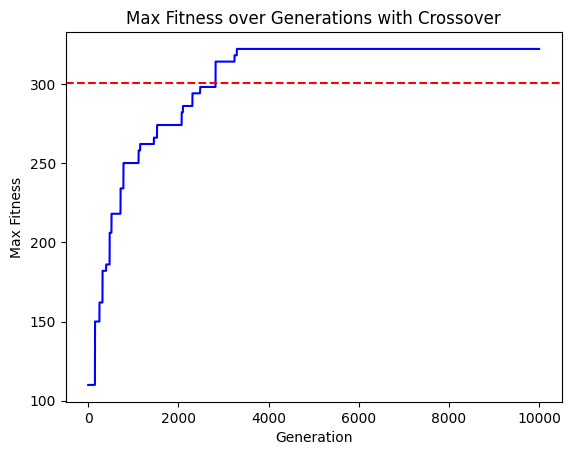

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(fitness_over_time_with_crossover, color='b')
plt.axhline(y=np.nanmean(fitness_over_time_with_crossover), linestyle='--', color='r')
plt.xlabel('Generation')
plt.ylabel('Max Fitness')
plt.title('Max Fitness over Generations with Crossover')

It is clear from above that the GA with crossover converged immediately after 2000 generations. Then it remained stable in the converged value.

In [23]:
np.mean(fitness_over_time_with_crossover)

300.7116

### Now let's run it without crossover.

In [8]:
np.random.seed(42)

ga_without_crossover = MicrobialEvolutionGA(population, w, 40_000, N_GENES, CROSSOVER_RATE, MUTATION_RATE, False)
fitness_over_time_without_crossover = ga_without_crossover.evolution()
ga_without_crossover.max_fitness_so_far(), ga_without_crossover.best_solution_so_far()

(174.0,
 array([ 1,  1,  1,  1, -1,  1, -1, -1,  1,  1, -1,  1,  1, -1, -1,  1, -1,
         1, -1,  1, -1, -1, -1,  1, -1, -1,  1, -1, -1, -1,  1, -1, -1, -1,
         1, -1,  1, -1,  1,  1, -1,  1,  1, -1, -1, -1,  1, -1,  1,  1]))

Text(0.5, 1.0, 'Max Fitness over Generations without Crossover')

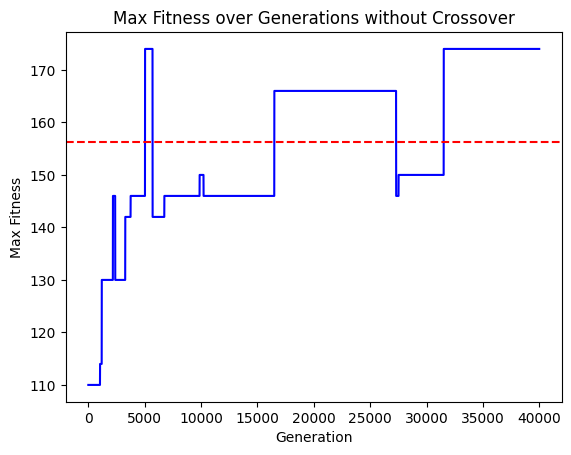

In [9]:
import matplotlib.pyplot as plt

plt.plot(fitness_over_time_without_crossover, color='b')
plt.axhline(y=np.nanmean(fitness_over_time_without_crossover), linestyle='--', color='r')
plt.xlabel('Generation')
plt.ylabel('Max Fitness')
plt.title('Max Fitness over Generations without Crossover')

On the other hand the GA without crossover didn't converge even after 40000 generations. Also it's not steady. It went down several times, but kept an upward trend in general.

In [22]:
np.mean(fitness_over_time_without_crossover)

156.2853

### Let's check the effect of varying crossover rates on fitness.

In [10]:
# Function to run GA algorithm for a given crossover rate and a mutation rate
# and return the maximum fitness.
def get_max_fitness_with_mutation_and_crossover(crossover_rate, mutation_rate):
    evolution_ga = MicrobialEvolutionGA(population, w, 3000, N_GENES, crossover_rate, mutation_rate, True)
    evolution_ga.evolution()
    return evolution_ga.max_fitness_so_far()

In [11]:
from numpy import arange

crossover_rates = arange(0.1, 0.9, 0.05)

max_fitness_for_crossovers = [get_max_fitness_with_mutation_and_crossover(crossover_rate, MUTATION_RATE) for crossover_rate in crossover_rates]

Text(0.5, 1.0, 'Max Fitness for Different Crossover Rates')

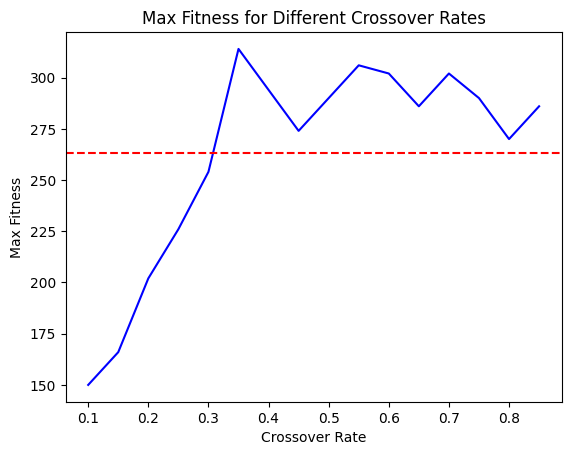

In [12]:
import matplotlib.pyplot as plt

plt.plot(crossover_rates, max_fitness_for_crossovers, color='b')
plt.axhline(y=np.nanmean(max_fitness_for_crossovers), linestyle='--', color='r')
plt.xlabel('Crossover Rate')
plt.ylabel('Max Fitness')
plt.title('Max Fitness for Different Crossover Rates')

According to above, fitness is generally following an increasing trend with increasing crossover rate. The maximum fitness is at 0.35 crossover rate. Above 0.35 it fluctuated.

In [13]:
best_performing_crossover_rate = crossover_rates[np.argmax(max_fitness_for_crossovers)]
best_performing_crossover_rate

0.3500000000000001

Best fitness is achieved while crossover rate is 0.35.

In [21]:
np.mean(max_fitness_for_crossovers)

263.25

### Let's check the effect of varying mutation rates on fitness, without using crossover.

In [14]:
# Function to run GA algorithm for a given mutation rate and no crossover
# and return the maximum fitness.
def get_max_fitness_with_mutation_only(mutation_rate):
    evolution_ga = MicrobialEvolutionGA(population, w, 4000, N_GENES, 0, mutation_rate, False)
    evolution_ga.evolution()
    return evolution_ga.max_fitness_so_far()

In [15]:
from numpy import arange

mutation_rates = arange(0.0, 0.9, 0.02)

max_fitness_for_mutations = [get_max_fitness_with_mutation_only(mutation_rate) for mutation_rate in mutation_rates]

Text(0.5, 1.0, 'Max Fitness for Different Mutation Rates (No Crossover)')

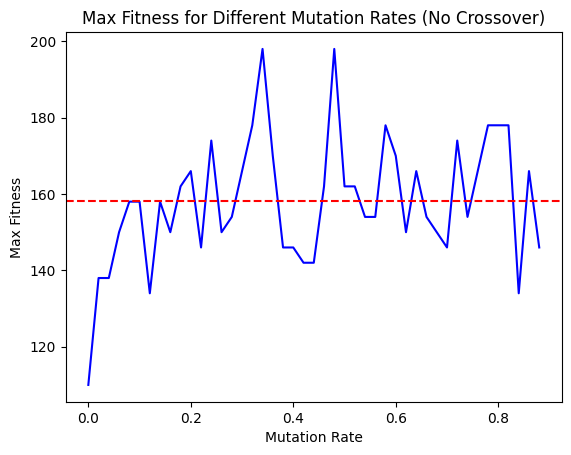

In [16]:
import matplotlib.pyplot as plt

plt.plot(mutation_rates, max_fitness_for_mutations, color='b')
plt.axhline(y=np.nanmean(max_fitness_for_mutations), linestyle='--', color='r')
plt.xlabel('Mutation Rate')
plt.ylabel('Max Fitness')
plt.title('Max Fitness for Different Mutation Rates (No Crossover)')

According to the above, fitness is not following any trend, it's just random. The average fitness is not good too.

In [20]:
np.mean(max_fitness_for_mutations)

158.0888888888889

### Let's check the effect of varying mutation rates on fitness, while using a fixed crossover rate.

We will use the best performing crossover rate as found above.

In [17]:
max_fitness_for_mutations_fixed_crossover = [get_max_fitness_with_mutation_and_crossover(mutation_rate, best_performing_crossover_rate) for mutation_rate in mutation_rates]

Text(0.5, 1.0, 'Max Fitness for Different Mutation Rates (Fixed Crossover)')

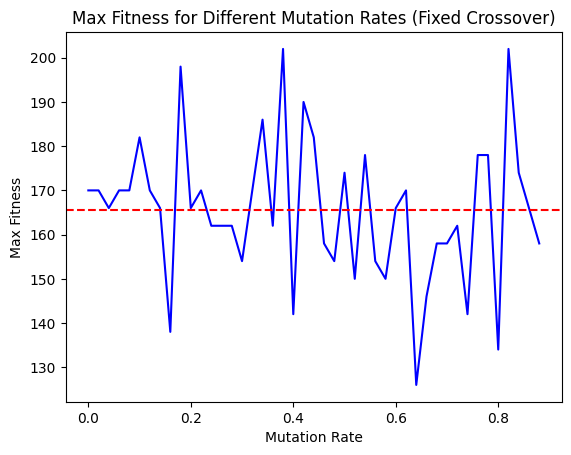

In [18]:
import matplotlib.pyplot as plt

plt.plot(mutation_rates, max_fitness_for_mutations_fixed_crossover, color='b')
plt.axhline(y=np.nanmean(max_fitness_for_mutations_fixed_crossover), linestyle='--', color='r')
plt.xlabel('Mutation Rate')
plt.ylabel('Max Fitness')
plt.title('Max Fitness for Different Mutation Rates (Fixed Crossover)')

According to the above, fitness is not following any trend again, it's random here too. The average fitness is better than not using crossover.

In [19]:
np.mean(max_fitness_for_mutations_fixed_crossover)

165.46666666666667